/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.1932 - val_loss: 0.0105
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0370 - val_loss: 0.0036
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0225 - val_loss: 0.0041
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0199 - val_loss: 0.0047
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0167 - val_loss: 0.0020
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0172 - val_loss: 0.0053
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0166 - val_loss: 0.0021
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0145 - val_loss: 0.0024
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0138 - val_loss: 0.0021
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - val_loss: 0.0027
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0122 - val_loss: 0.0027
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0

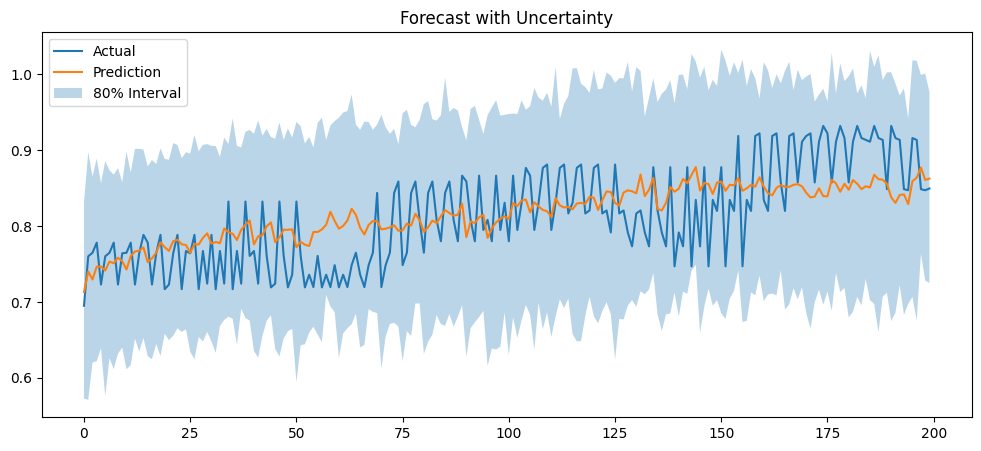

In [6]:
"""
Advanced Time Series Forecasting with Neural Networks
and Uncertainty Quantification (Single File)

Author: Preetha Devi
"""

# ===============================
# 1. Imports
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# ===============================
# 2. Generate Multivariate Data
# ===============================
def generate_multivariate_series(n_steps=1200):
    t = np.arange(n_steps)

    f1 = np.sin(0.02 * t) + np.random.normal(0, 0.1, n_steps)
    f2 = 0.7 * f1 + np.random.normal(0, 0.1, n_steps)
    f3 = np.cos(0.02 * t) + np.random.normal(0, 0.1, n_steps)

    y = 0.5 * f1 + 0.3 * f2 + 0.2 * f3 + np.random.normal(0, 0.05, n_steps)

    return pd.DataFrame({"f1": f1, "f2": f2, "f3": f3, "y": y})


data = generate_multivariate_series()

# ===============================
# 3. Scaling & Sequence Creation
# ===============================
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

def create_sequences(data, window=30, horizon=5):
    X, y = [], []
    for i in range(len(data) - window - horizon):
        X.append(data[i:i+window, :-1])
        y.append(data[i+window:i+window+horizon, -1])
    return np.array(X), np.array(y)

WINDOW = 30
HORIZON = 5

X, y = create_sequences(scaled, WINDOW, HORIZON)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ===============================
# 4. LSTM Model with Dropout
# ===============================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 3)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(HORIZON)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ===============================
# 5. Monte Carlo Dropout
# ===============================
def mc_dropout_predictions(model, X, n_samples=100):
    preds = []
    for _ in range(n_samples):
        preds.append(model(X, training=True).numpy())
    return np.array(preds)

mc_preds = mc_dropout_predictions(model, X_test)
mean_preds = mc_preds.mean(axis=0)

# ===============================
# 6. Prediction Intervals
# ===============================
def prediction_interval(preds, confidence):
    lower = np.percentile(preds, (1 - confidence) / 2 * 100, axis=0)
    upper = np.percentile(preds, (1 + confidence) / 2 * 100, axis=0)
    return lower, upper

lower_80, upper_80 = prediction_interval(mc_preds, 0.80)
lower_95, upper_95 = prediction_interval(mc_preds, 0.95)

# ===============================
# 7. Metrics & Coverage
# ===============================
rmse = np.sqrt(mean_squared_error(y_test.flatten(), mean_preds.flatten()))
mae = mean_absolute_error(y_test.flatten(), mean_preds.flatten())

def coverage_rate(y_true, lower, upper):
    return np.mean((y_true >= lower) & (y_true <= upper))

cov_80 = coverage_rate(y_test, lower_80, upper_80)
cov_95 = coverage_rate(y_test, lower_95, upper_95)

# ===============================
# 8. SARIMAX Baseline
# ===============================
sarimax_model = SARIMAX(data["y"][:split + WINDOW], order=(1, 1, 1))
sarimax_fit = sarimax_model.fit(disp=False)

sarimax_forecast = sarimax_fit.forecast(
    steps=len(y_test.flatten())
)

sarimax_rmse = np.sqrt(
    mean_squared_error(y_test.flatten(), sarimax_forecast)
)

# ===============================
# 9. Results
# ===============================
print("\n===== POINT FORECAST METRICS =====")
print(f"LSTM RMSE     : {rmse:.4f}")
print(f"LSTM MAE      : {mae:.4f}")
print(f"SARIMAX RMSE  : {sarimax_rmse:.4f}")

print("\n===== UNCERTAINTY METRICS =====")
print(f"80% Coverage  : {cov_80:.2f}")
print(f"95% Coverage  : {cov_95:.2f}")

# ===============================
# 10. Visualization
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(y_test.flatten()[:200], label="Actual")
plt.plot(mean_preds.flatten()[:200], label="Prediction")

plt.fill_between(
    range(200),
    lower_80.flatten()[:200],
    upper_80.flatten()[:200],
    alpha=0.3,
    label="80% Interval"
)

plt.title("Forecast with Uncertainty")
plt.legend()
plt.show()
